In [1]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


CUDA Available: True
Device Name: NVIDIA GeForce RTX 4050 Laptop GPU


Files already downloaded and verified
Files already downloaded and verified
X_train: (50000, 32, 32, 3)
Y_train: (50000,)
X_test: (10000, 32, 32, 3)
Y_test: (10000,)


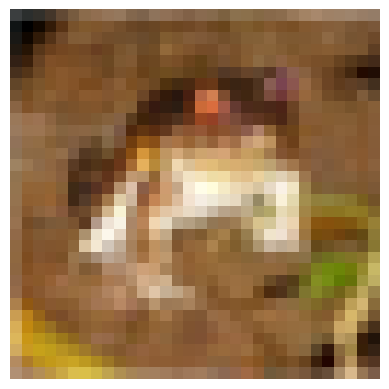

Embeddings: (1000, 288)
Test Embeddings: (200, 288)
PyTorch PCA test accuracy: 26.5 %
PyTorch QRC test accuracy: 28.0 %
PyTorch Simple NN test accuracy: 26.0 %
Linear SVM test accuracy (PCA): 23.0 %


C:\Users\Priyanshi\anaconda3\envs\qisk\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVC RBF Kernel test accuracy (PCA): 23.0 %


C:\Users\Priyanshi\anaconda3\envs\qisk\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVM test accuracy (QRC): 27.0 %
SVC RBF Kernel test accuracy (QRC): 30.0 %


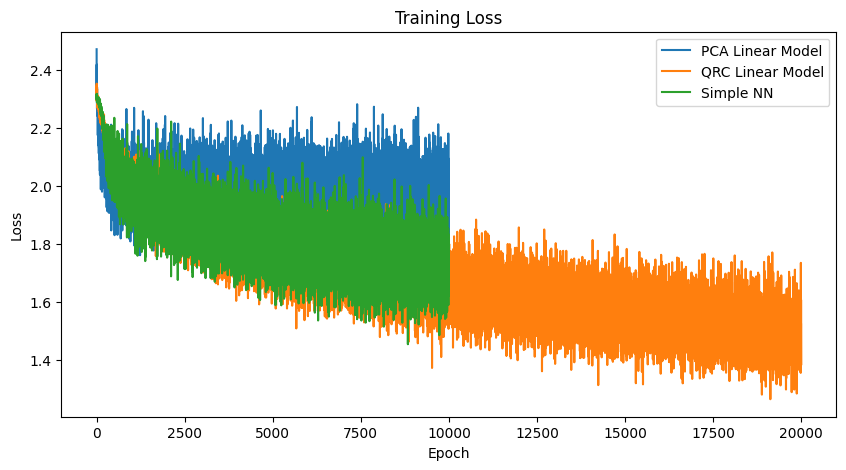

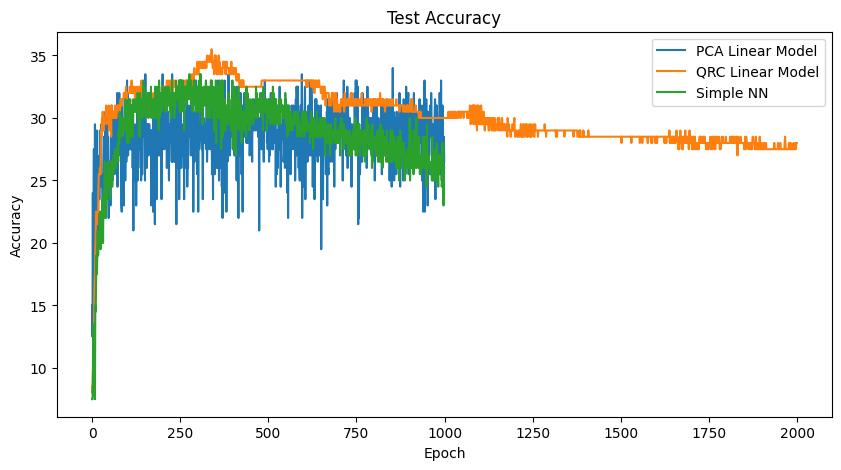

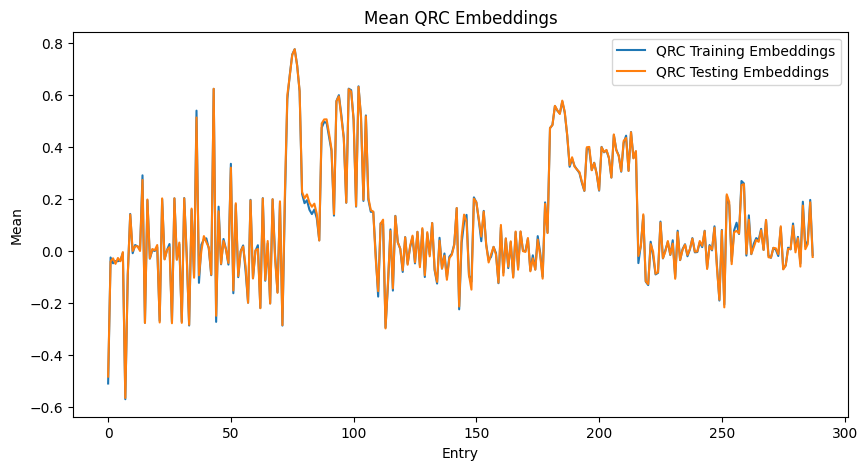

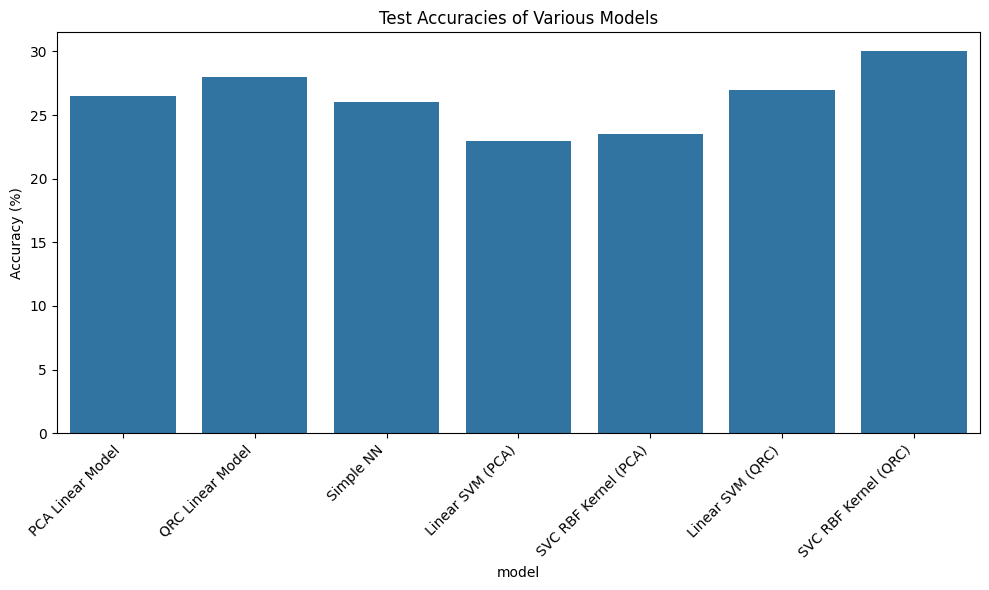

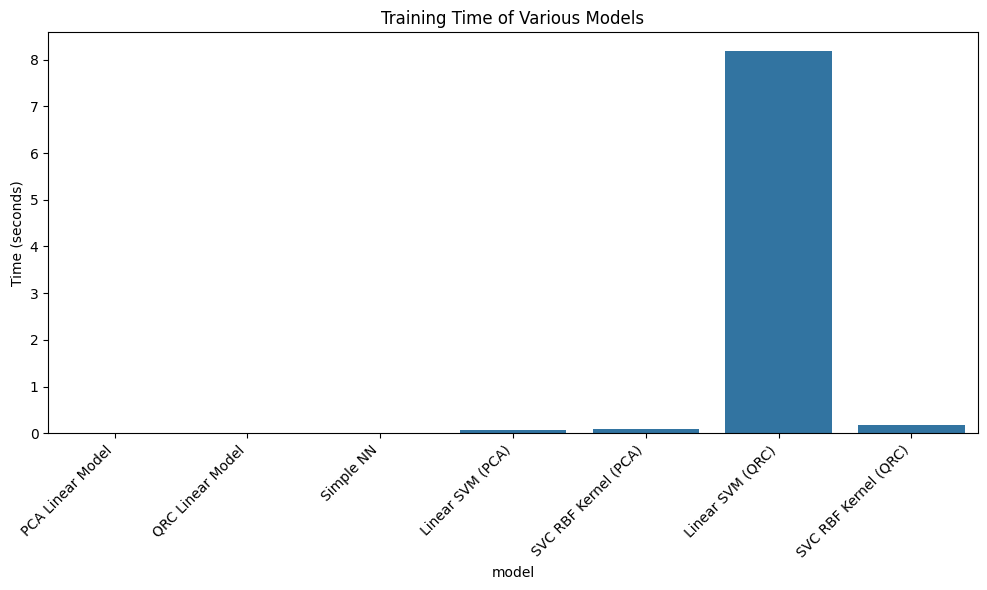

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
import bloqade
from bloqade.ir.location import Chain, start
import seaborn as sns
import pandas as pd
from time import time
from sklearn.preprocessing import StandardScaler

#####################################################################
# 1. Data Loading and Preprocessing (CIFAR-10)
#####################################################################

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_X = train_dataset.data.astype(np.float32) / 255.0
train_y = np.array(train_dataset.targets)
test_X = test_dataset.data.astype(np.float32) / 255.0
test_y = np.array(test_dataset.targets)

# Data Dimensions
print('X_train:', train_X.shape)  # Should be (50000, 32, 32, 3)
print('Y_train:', train_y.shape)
print('X_test:', test_X.shape)    # Should be (10000, 32, 32, 3)
print('Y_test:', test_y.shape)

# Display an example
plt.imshow(train_X[0])
plt.axis('off')
plt.show()


#####################################################################
# 2. PCA Dimensionality Reduction
#####################################################################

dim_pca = 8
num_examples = 1000  # Limit the training set
num_test_examples = 200 # limit the test set

# Reshape images for PCA
train_X_reshaped = np.reshape(train_X, (len(train_X), -1))
test_X_reshaped = np.reshape(test_X, (len(test_X), -1))


# PCA Model and Transformation
pca = PCA(n_components=dim_pca)
pca.fit(train_X_reshaped)  # Fit PCA on train set
xs = pca.transform(train_X_reshaped)[:num_examples, :]
xt = pca.transform(test_X_reshaped)[:num_test_examples, :]

# Scaling the PCA components
spectral = np.amax(xs) - np.amin(xs)
m1 = np.amin(xs)
xs = (xs - m1) / spectral  # Values between 0 and 1
xs_test = (xt - m1)/spectral


#####################################################################
# 3. Bloqade QRC Parameters and Functions
#####################################################################

QRC_parameters = {
    "atom_number": dim_pca,
    "geometry_spec": Chain(dim_pca, lattice_spacing=10),
    "encoding_scale": 9.0,
    "rabi_frequency": 6.283,
    "total_time": 4,
    "time_steps": 8,
    "readouts": "ZZ",
}

# Function to build Bloqade tasks
def build_task(QRC_parameters, xs1):
    natoms = QRC_parameters["atom_number"]
    encoding_scale = QRC_parameters["encoding_scale"]
    dt = QRC_parameters["total_time"] / QRC_parameters["time_steps"]
    rabi_oscillations_program = (
        QRC_parameters["geometry_spec"]
        .rydberg.rabi.amplitude.uniform.constant(
            duration="run_time", value=QRC_parameters["rabi_frequency"]
        )
        .detuning.uniform.constant(duration="run_time", value=encoding_scale / 2)
        .scale(list(xs1)).constant(duration="run_time", value=-encoding_scale)
    )
    rabi_oscillation_job = rabi_oscillations_program.batch_assign(
        run_time=np.arange(1, QRC_parameters["time_steps"] + 1, 1) * dt
    )
    return rabi_oscillation_job

# Function to process simulation results
def process_results(QRC_parameters, report):
    embedding = []
    natoms = QRC_parameters["atom_number"]
    try:
        for t in range(QRC_parameters["time_steps"]):
            ar1 = -1.0 + 2 * ((report.bitstrings())[t])
            nsh1 = ar1.shape[0]
            for i in range(natoms):
                embedding.append(np.sum(ar1[:, i]) / nsh1)
            if QRC_parameters["readouts"] == "ZZ":
                for i in range(natoms):
                    for j in range(i + 1, natoms):
                        embedding.append(np.sum(ar1[:, i] * ar1[:, j]) / nsh1)
    except:
        print("No results exist.")
        for t in range(QRC_parameters["time_steps"]):
            for i in range(natoms):
                embedding.append(0.0)
            if QRC_parameters["readouts"] == "ZZ":
                for i in range(natoms):
                    for j in range(i + 1, natoms):
                        embedding.append(0.0)
    return embedding

# Function to process sample results (No expectation)
def process_results_samples(QRC_parameters, report):
  embedding=[]
  try:
      embedding=report.bitstrings()
  except:
      print("No results exist.")
      for t in range(QRC_parameters["time_steps"]):
          for i in range(natoms):
              embedding.append(0.0)
          if QRC_parameters["readouts"]=="ZZ":
              for i in range(natoms):
                  for j in range(i+1,natoms):
                      embedding.append(0.0)
  return embedding

# Function to get embeddings using Bloqade simulation
def get_embeddings_emulation(xs, num_examples, nshots=1000):
    return np.array([
        process_results(
            QRC_parameters,
            build_task(QRC_parameters, xs[data, :])
            .bloqade.python()
            .run(shots=nshots, rtol=1e-8, atol=1e-8)
            .report(),
        )
        for data in range(num_examples)
    ])


#####################################################################
# 4. Generate QRC Embeddings
#####################################################################
embeddings = get_embeddings_emulation(xs, num_examples, nshots=1000)
test_embeddings = get_embeddings_emulation(xs_test, num_test_examples, nshots=1000)


print("Embeddings:", embeddings.shape) # Should be (1000, 288)
print("Test Embeddings:", test_embeddings.shape) # Should be (200, 288)


#####################################################################
# 5. PyTorch Models
#####################################################################

# Linear Model in PyTorch
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Simple Neural Network in PyTorch
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

#####################################################################
# 6. Training/Testing Utility Functions
#####################################################################
def train_and_test_pytorch(model, train_data, train_targets, test_data, test_targets, num_epochs, batch_size, learning_rate):
        # Convert data to tensors
        train_data = torch.tensor(train_data, dtype=torch.float32)
        train_targets = torch.tensor(train_targets, dtype=torch.int64)
        test_data = torch.tensor(test_data, dtype=torch.float32)
        test_targets = torch.tensor(test_targets, dtype=torch.int64)

        #Data load for batched operations
        train_dataset = TensorDataset(train_data, train_targets)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataset = TensorDataset(test_data, test_targets)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Loss function and optimizers
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=0.0002)


        # Training loop
        losses = []
        accuracies = []
        for epoch in range(num_epochs):
            model.train()
            for batch_data, batch_targets in train_loader:
                optimizer.zero_grad()  # Reset gradients
                outputs = model(batch_data)
                loss = criterion(outputs, batch_targets)
                loss.backward() # Calculate gradients
                optimizer.step() # Update weights
                losses.append(loss.item())

            # Evaluation of the accuracy
            model.eval()  # Switch model to evaluation mode
            correct = 0
            total = 0
            with torch.no_grad():  # Do not track gradients during evaluation
                for batch_data, batch_targets in test_loader:
                    outputs = model(batch_data)
                    _, predicted = torch.max(outputs.data, 1)
                    total += batch_targets.size(0)
                    correct += (predicted == batch_targets).sum().item()
            accuracies.append(100 * correct / total)

        test_accuracy = 100 * correct / total
        return test_accuracy, losses, accuracies

#####################################################################
# 7. Training and Testing (PCA Baseline)
#####################################################################

# Linear Classification on PCA data using PyTorch
model_pca = LinearModel(input_size=xs.shape[1], output_size=10)
pca_accuracy, pca_losses, pca_accuracies = train_and_test_pytorch(
        model_pca,
        xs,
        train_y[:num_examples],
        xs_test,
        test_y[:num_test_examples],
        num_epochs=1000,
        batch_size=100,
        learning_rate=0.1
    )
print('PyTorch PCA test accuracy:', round(pca_accuracy, 2), "%")

#####################################################################
# 8. Training and Testing (QRC Embeddings)
#####################################################################

# Linear Classification on QRC embeddings using PyTorch
model_qrc = LinearModel(input_size=embeddings.shape[1], output_size=10)
qrc_accuracy, qrc_losses, qrc_accuracies = train_and_test_pytorch(
        model_qrc,
        embeddings,
        train_y[:num_examples],
        test_embeddings,
        test_y[:num_test_examples],
        num_epochs=2000,
        batch_size=100,
        learning_rate=0.0002
    )
print('PyTorch QRC test accuracy:', round(qrc_accuracy, 2), "%")


#####################################################################
# 9. Training and Testing (Simple NN on PCA)
#####################################################################

# Simple NN on PCA Data
model_nn = SimpleNN(input_size=xs.shape[1], hidden_size=50, output_size=10)
nn_accuracy, nn_losses, nn_accuracies = train_and_test_pytorch(
        model_nn,
        xs,
        train_y[:num_examples],
        xs_test,
        test_y[:num_test_examples],
        num_epochs=1000,
        batch_size=100,
        learning_rate=0.001
)

print('PyTorch Simple NN test accuracy:', round(nn_accuracy, 2), "%")

#####################################################################
# 10. Training and Testing (Linear and RBF Kernel SVM/SVC)
#####################################################################

# Linear SVM on PCA features
svm_pca = LinearSVC(C=1.0, multi_class='crammer_singer', dual=False)
svm_start_time = time()
svm_pca.fit(xs, train_y[:num_examples])
svm_pca_time = time() - svm_start_time
y_pred = svm_pca.predict(xs_test)
accuracy = svm_pca.score(xs_test, test_y[:num_test_examples])
print('Linear SVM test accuracy (PCA):', 100*round(accuracy, 2), "%")

# SVC RBF Kernel on PCA features
svm_rbf_pca = SVC(C=8.)
svm_rbf_start_time = time()
svm_rbf_pca.fit(xs, train_y[:num_examples])
svm_rbf_pca_time = time() - svm_rbf_start_time
y_pred = svm_rbf_pca.predict(xs_test)
accuracy = svm_rbf_pca.score(xs_test, test_y[:num_test_examples])
print('SVC RBF Kernel test accuracy (PCA):', 100*round(accuracy, 2), "%")

# Linear SVM on QRC Embeddings
svm_qrc = LinearSVC(C=1.0, multi_class='crammer_singer', dual=False)
svm_start_time = time()
svm_qrc.fit(embeddings, train_y[:num_examples])
svm_qrc_time = time() - svm_start_time
y_pred = svm_qrc.predict(test_embeddings)
accuracy = svm_qrc.score(test_embeddings, test_y[:num_test_examples])
print('Linear SVM test accuracy (QRC):', 100*round(accuracy, 2), "%")

# SVC RBF Kernel on QRC Embeddings
svm_rbf_qrc = SVC(C=8.)
svm_rbf_start_time = time()
svm_rbf_qrc.fit(embeddings, train_y[:num_examples])
svm_rbf_qrc_time = time() - svm_rbf_start_time
y_pred = svm_rbf_qrc.predict(test_embeddings)
accuracy = svm_rbf_qrc.score(test_embeddings, test_y[:num_test_examples])
print('SVC RBF Kernel test accuracy (QRC):', 100*round(accuracy, 2), "%")


#####################################################################
# 11. Plotting
#####################################################################

# Plot training losses for the neural nets
plt.figure(figsize=(10, 5))
plt.plot(pca_losses, label="PCA Linear Model")
plt.plot(qrc_losses, label="QRC Linear Model")
plt.plot(nn_losses, label="Simple NN")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training accuracies for the neural nets
plt.figure(figsize=(10, 5))
plt.plot(pca_accuracies, label="PCA Linear Model")
plt.plot(qrc_accuracies, label="QRC Linear Model")
plt.plot(nn_accuracies, label="Simple NN")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


#Plot the QRC Embeddings mean value
mean_embed = np.mean(embeddings, axis=0)
mean_test_embed = np.mean(test_embeddings, axis=0)
plt.figure(figsize=(10, 5))
plt.plot(mean_embed, label = "QRC Training Embeddings")
plt.plot(mean_test_embed, label="QRC Testing Embeddings")
plt.title("Mean QRC Embeddings")
plt.xlabel("Entry")
plt.ylabel("Mean")
plt.legend()
plt.show()


#Data for the final performance plot
results = {
    "model": [
        "PCA Linear Model",
        "QRC Linear Model",
        "Simple NN",
        "Linear SVM (PCA)",
        "SVC RBF Kernel (PCA)",
        "Linear SVM (QRC)",
        "SVC RBF Kernel (QRC)",
    ],
    "accuracy": [
        pca_accuracy,
        qrc_accuracy,
        nn_accuracy,
        100*svm_pca.score(xs_test, test_y[:num_test_examples]),
        100*svm_rbf_pca.score(xs_test, test_y[:num_test_examples]),
        100*svm_qrc.score(test_embeddings, test_y[:num_test_examples]),
        100*svm_rbf_qrc.score(test_embeddings, test_y[:num_test_examples]),
    ],
     "training_time": [
        0,0,0,
        svm_pca_time,
        svm_rbf_pca_time,
        svm_qrc_time,
        svm_rbf_qrc_time,
    ]
}

df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
sns.barplot(x="model", y="accuracy", data=df)
plt.title("Test Accuracies of Various Models")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy (%)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="model", y="training_time", data=df)
plt.title("Training Time of Various Models")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Time (seconds)")
plt.tight_layout()
plt.show()

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
import bloqade
from bloqade.ir.location import Chain, start
import seaborn as sns
import pandas as pd
from time import time
from sklearn.preprocessing import StandardScaler


Files already downloaded and verified
Files already downloaded and verified
X_train: (50000, 32, 32, 3)
Y_train: (50000,)
X_test: (10000, 32, 32, 3)
Y_test: (10000,)


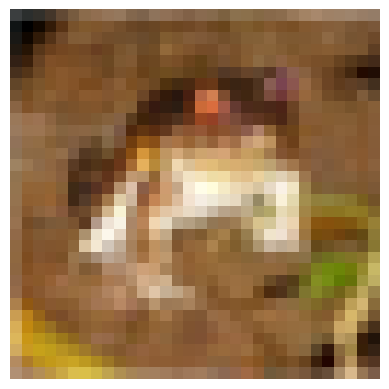

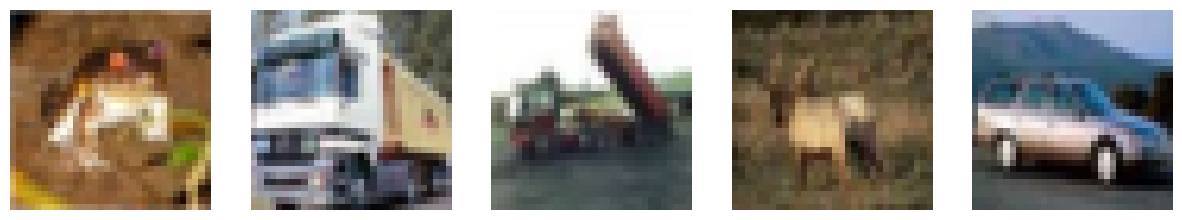

Min train data =  0.0
Max train data =  1.0
Min test data =  0.0
Max test data =  1.0


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_X = train_dataset.data.astype(np.float32) / 255.0
train_y = np.array(train_dataset.targets)
test_X = test_dataset.data.astype(np.float32) / 255.0
test_y = np.array(test_dataset.targets)

# Data Dimensions
print('X_train:', train_X.shape)  # Should be (50000, 32, 32)
print('Y_train:', train_y.shape)
print('X_test:', test_X.shape)    # Should be (10000, 32, 32)
print('Y_test:', test_y.shape)

# Display an example
plt.imshow(train_X[0], cmap='gray')
plt.axis('off')
plt.show()

# Display first few images in our training data
num_images_to_show = 5
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))
for i in range(num_images_to_show):
    axes[i].imshow(train_X[i], cmap='gray')
    axes[i].axis('off')
plt.show()
#Display the mean of the datasets
print("Min train data = ", np.min(train_X))
print("Max train data = ", np.max(train_X))
print("Min test data = ", np.min(test_X))
print("Max test data = ", np.max(test_X))

In [4]:
dim_pca = 8
num_examples = 1000  # Limit the training set
num_test_examples = 200 # limit the test set

# Reshape images for PCA
train_X_reshaped = np.reshape(train_X, (len(train_X), -1))
test_X_reshaped = np.reshape(test_X, (len(test_X), -1))


# PCA Model and Transformation
pca = PCA(n_components=dim_pca)
pca.fit(train_X_reshaped)  # Fit PCA on train set
xs = pca.transform(train_X_reshaped)[:num_examples, :]
xt = pca.transform(test_X_reshaped)[:num_test_examples, :]

# Scaling the PCA components
spectral = np.amax(xs) - np.amin(xs)
m1 = np.amin(xs)
xs = (xs - m1) / spectral  # Values between 0 and 1
xs_test = (xt - m1)/spectral

print("Min PCA = ", np.min(xs))
print("Max PCA = ", np.max(xs))

Min PCA =  0.0
Max PCA =  1.0


In [5]:
QRC_parameters = {
    "atom_number": dim_pca,
    "geometry_spec": Chain(dim_pca, lattice_spacing=10),
    "encoding_scale": 15.0,
    "rabi_frequency": 3.0,
    "total_time": 6,
    "time_steps": 8,
    "readouts": "ZZ",
}

# Function to build Bloqade tasks (local detuning)
def build_task_local(QRC_parameters, xs1):
    natoms=QRC_parameters["atom_number"]
    encoding_scale=QRC_parameters["encoding_scale"]
    dt=QRC_parameters["total_time"]/QRC_parameters["time_steps"]
    #builds global Rabi and detuning pulses
    rabi_oscillations_program = (QRC_parameters["geometry_spec"]
        .rydberg.rabi.amplitude.uniform.constant(
            duration="run_time", value=QRC_parameters["rabi_frequency"]
        )
        .detuning.uniform.constant(duration="run_time", value=encoding_scale/2)
        .scale(list(xs1)).constant(duration="run_time", value=-encoding_scale)
        )
    rabi_oscillation_job = rabi_oscillations_program.batch_assign(run_time=np.arange(1, QRC_parameters["time_steps"]+1, 1)*dt)
    return rabi_oscillation_job

# Function to build Bloqade tasks (global detuning)
def build_task_global(QRC_parameters, xs1):
    natoms=QRC_parameters["atom_number"]
    encoding_scale=QRC_parameters["encoding_scale"]
    dt=QRC_parameters["total_time"]/QRC_parameters["time_steps"]
    #builds global Rabi and detuning pulses
    rabi_oscillations_program = (QRC_parameters["geometry_spec"]
        .rydberg.rabi.amplitude.uniform.constant(
            duration="run_time", value=QRC_parameters["rabi_frequency"]
        )
        .detuning.uniform.constant(duration="run_time", value=encoding_scale/2)
        #adds a global detuning that depends on the whole input vector
        .constant(duration="run_time", value=-encoding_scale * np.sum(xs1))
        )
    rabi_oscillation_job = rabi_oscillations_program.batch_assign(run_time=np.arange(1, QRC_parameters["time_steps"]+1, 1)*dt)
    return rabi_oscillation_job

# Function to build Bloqade tasks (hybrid detuning)
def build_task_hybrid(QRC_parameters, xs1):
   natoms=QRC_parameters["atom_number"]
   encoding_scale=QRC_parameters["encoding_scale"]
   dt=QRC_parameters["total_time"]/QRC_parameters["time_steps"]
   #builds global Rabi and detuning pulses
   rabi_oscillations_program = (QRC_parameters["geometry_spec"]
        .rydberg.rabi.amplitude.uniform.constant(
            duration="run_time", value=QRC_parameters["rabi_frequency"]
        )
        .detuning.uniform.constant(duration="run_time", value=encoding_scale/2)
        #adds a global detuning that depends on the whole input vector and also adds local terms
        .constant(duration="run_time", value=-encoding_scale*np.sum(xs1)/natoms)
        .scale(list(xs1)).constant(duration="run_time", value=-encoding_scale/natoms)

        )
   rabi_oscillation_job = rabi_oscillations_program.batch_assign(run_time=np.arange(1, QRC_parameters["time_steps"]+1, 1)*dt)
   return rabi_oscillation_job


# Function to process simulation results
def process_results(QRC_parameters, report):
    embedding = []
    natoms = QRC_parameters["atom_number"]
    try:
        for t in range(QRC_parameters["time_steps"]):
            ar1 = -1.0 + 2 * ((report.bitstrings())[t])
            nsh1 = ar1.shape[0]
            for i in range(natoms):
                embedding.append(np.sum(ar1[:, i]) / nsh1)
            if QRC_parameters["readouts"] == "ZZ":
                for i in range(natoms):
                    for j in range(i + 1, natoms):
                        embedding.append(np.sum(ar1[:, i] * ar1[:, j]) / nsh1)
    except:
        print("No results exist.")
        for t in range(QRC_parameters["time_steps"]):
            for i in range(natoms):
                embedding.append(0.0)
            if QRC_parameters["readouts"] == "ZZ":
                for i in range(natoms):
                    for j in range(i + 1, natoms):
                        embedding.append(0.0)
    return embedding

# Function to process sample results (No expectation)
def process_results_samples(QRC_parameters, report):
  embedding=[]
  try:
      embedding=report.bitstrings()
  except:
      print("No results exist.")
      for t in range(QRC_parameters["time_steps"]):
          for i in range(natoms):
              embedding.append(0.0)
          if QRC_parameters["readouts"]=="ZZ":
              for i in range(natoms):
                  for j in range(i+1,natoms):
                      embedding.append(0.0)
  return embedding

# Function to get embeddings using Bloqade simulation (local)
def get_embeddings_emulation_local(xs, num_examples, nshots=10000, num_parallel=5):
    return np.array([
        process_results(
            QRC_parameters,
            build_task_local(QRC_parameters, xs[data, :])
            .parallelize(num_parallel)
            .bloqade.python()
            .run(shots=nshots, rtol=1e-8, atol=1e-8)
            .report(),
        )
        for data in range(num_examples)
    ])
# Function to get embeddings using Bloqade simulation (global)
def get_embeddings_emulation_global(xs, num_examples, nshots=10000, num_parallel = 5):
    return np.array([
        process_results(
            QRC_parameters,
            build_task_global(QRC_parameters, xs[data, :])
            .parallelize(num_parallel)
            .bloqade.python()
            .run(shots=nshots, rtol=1e-8, atol=1e-8)
            .report(),
        )
        for data in range(num_examples)
    ])

# Function to get embeddings using Bloqade simulation (hybrid)
def get_embeddings_emulation_hybrid(xs, num_examples, nshots=10000, num_parallel = 5):
    return np.array([
        process_results(
            QRC_parameters,
            build_task_hybrid(QRC_parameters, xs[data, :])
            .parallelize(num_parallel)
            .bloqade.python()
            .run(shots=nshots, rtol=1e-8, atol=1e-8)
            .report(),
        )
        for data in range(num_examples)
    ])


In [ ]:
embeddings_local = get_embeddings_emulation_local(xs, num_examples, nshots=10000)
test_embeddings_local = get_embeddings_emulation_local(xs_test, num_test_examples, nshots=10000)
embeddings_global = get_embeddings_emulation_global(xs, num_examples, nshots=10000)
test_embeddings_global = get_embeddings_emulation_global(xs_test, num_test_examples, nshots=10000)
embeddings_hybrid = get_embeddings_emulation_hybrid(xs, num_examples, nshots=10000)
test_embeddings_hybrid = get_embeddings_emulation_hybrid(xs_test, num_test_examples, nshots=10000)


#Plot the QRC Embeddings mean value
mean_embed = np.mean(embeddings_local, axis=0)
mean_test_embed = np.mean(test_embeddings_local, axis=0)
plt.figure(figsize=(10, 5))
plt.plot(mean_embed, label = "QRC Local Training Embeddings")
plt.plot(mean_test_embed, label="QRC Local Testing Embeddings")
plt.title("Mean QRC Embeddings Local")
plt.xlabel("Entry")
plt.ylabel("Mean")
plt.legend()
plt.show()

mean_embed = np.mean(embeddings_global, axis=0)
mean_test_embed = np.mean(test_embeddings_global, axis=0)
plt.figure(figsize=(10, 5))
plt.plot(mean_embed, label = "QRC Global Training Embeddings")
plt.plot(mean_test_embed, label="QRC Global Testing Embeddings")
plt.title("Mean QRC Embeddings Global")
plt.xlabel("Entry")
plt.ylabel("Mean")
plt.legend()
plt.show()

mean_embed = np.mean(embeddings_hybrid, axis=0)
mean_test_embed = np.mean(test_embeddings_hybrid, axis=0)
plt.figure(figsize=(10, 5))
plt.plot(mean_embed, label = "QRC Hybrid Training Embeddings")
plt.plot(mean_test_embed, label="QRC Hybrid Testing Embeddings")
plt.title("Mean QRC Embeddings Hybrid")
plt.xlabel("Entry")
plt.ylabel("Mean")
plt.legend()
plt.show()

print("Embeddings (local):", embeddings_local.shape) # Should be (1000, 288)
print("Test Embeddings (local):", test_embeddings_local.shape) # Should be (200, 288)
print("Embeddings (global):", embeddings_global.shape) # Should be (1000, 288)
print("Test Embeddings (global):", test_embeddings_global.shape) # Should be (200, 288)
print("Embeddings (hybrid):", embeddings_hybrid.shape) # Should be (1000, 288)
print("Test Embeddings (hybrid):", test_embeddings_hybrid.shape) # Should be (200, 288)



In [ ]:
# Linear Model in PyTorch
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Simple Neural Network in PyTorch
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# CNN Class
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels= 16, kernel_size = 5, padding = 2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size = 2)
        self.conv2 = nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = 5, padding = 2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size = 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, output_size)

    def forward(self, x):
      x = x.unsqueeze(1)
      x = self.relu1(self.conv1(x))
      x = self.pool1(x)
      x = self.relu2(self.conv2(x))
      x = self.pool2(x)
      x = self.flatten(x)
      x = self.fc1(x)
      return x

In [ ]:
def train_and_test_pytorch(model, train_data, train_targets, test_data, test_targets, num_epochs, batch_size, learning_rate, device):
        # Convert data to tensors
        train_data = torch.tensor(train_data, dtype=torch.float32).to(device)
        train_targets = torch.tensor(train_targets, dtype=torch.int64).to(device)
        test_data = torch.tensor(test_data, dtype=torch.float32).to(device)
        test_targets = torch.tensor(test_targets, dtype=torch.int64).to(device)

        #Data load for batched operations
        train_dataset = TensorDataset(train_data, train_targets)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataset = TensorDataset(test_data, test_targets)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Loss function and optimizers
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=0.0002)
        model.to(device)


        # Training loop
        losses = []
        accuracies = []
        for epoch in range(num_epochs):
            model.train()
            for batch_data, batch_targets in train_loader:
                batch_data = batch_data.to(device)
                batch_targets = batch_targets.to(device)
                optimizer.zero_grad()  # Reset gradients
                outputs = model(batch_data)
                loss = criterion(outputs, batch_targets)
                loss.backward() # Calculate gradients
                optimizer.step() # Update weights
                losses.append(loss.item())

            # Evaluation of the accuracy
            model.eval()  # Switch model to evaluation mode
            correct = 0
            total = 0
            with torch.no_grad():  # Do not track gradients during evaluation
                for batch_data, batch_targets in test_loader:
                    batch_data = batch_data.to(device)
                    batch_targets = batch_targets.to(device)
                    outputs = model(batch_data)
                    _, predicted = torch.max(outputs.data, 1)
                    total += batch_targets.size(0)
                    correct += (predicted == batch_targets).sum().item()
            accuracies.append(100 * correct / total)

        test_accuracy = 100 * correct / total

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


In [ ]:
# Linear Classification on PCA data using PyTorch
model_pca = LinearModel(input_size=xs.shape[1], output_size=10)
pca_accuracy, pca_losses, pca_accuracies = train_and_test_pytorch(
        model_pca,
        xs,
        train_y[:num_examples],
        xs_test,
        test_y[:num_test_examples],
        num_epochs=1000,
        batch_size=100,
        learning_rate=0.1,
        device = device
    )
print('PyTorch PCA test accuracy:', round(pca_accuracy, 2), "%")


In [ ]:
# Linear Classification on QRC embeddings using PyTorch (Local)
model_qrc_local = LinearModel(input_size=embeddings_local.shape[1], output_size=10)
qrc_accuracy_local, qrc_losses_local, qrc_accuracies_local = train_and_test_pytorch(
    model_qrc_local,
    embeddings_local,
    train_y[:num_examples],
    test_embeddings_local,
    test_y[:num_test_examples],
    num_epochs=2000,
    batch_size=100,
    learning_rate=0.0002,
    device = device
)
print('PyTorch QRC test accuracy (Local):', round(qrc_accuracy_local, 2), "%")


# Linear Classification on QRC embeddings using PyTorch (Global)
model_qrc_global = LinearModel(input_size=embeddings_global.shape[1], output_size=10)
qrc_accuracy_global, qrc_losses_global, qrc_accuracies_global = train_and_test_pytorch(
    model_qrc_global,
    embeddings_global,
    train_y[:num_examples],
    test_embeddings_global,
    test_y[:num_test_examples],
    num_epochs=2000,
    batch_size=100,
    learning_rate=0.0002,
    device = device
)
print('PyTorch QRC test accuracy (Global):', round(qrc_accuracy_global, 2), "%")

# Linear Classification on QRC embeddings using PyTorch (Hybrid)
model_qrc_hybrid = LinearModel(input_size=embeddings_hybrid.shape[1], output_size=10)
qrc_accuracy_hybrid, qrc_losses_hybrid, qrc_accuracies_hybrid = train_and_test_pytorch(
    model_qrc_hybrid,
    embeddings_hybrid,
    train_y[:num_examples],
    test_embeddings_hybrid,
    test_y[:num_test_examples],
    num_epochs=2000,
    batch_size=100,
    learning_rate=0.0002,
    device = device
)
print('PyTorch QRC test accuracy (Hybrid):', round(qrc_accuracy_hybrid, 2), "%")
#####################################################################
# 9. Training and Testing (Simple NN on PCA)
#####################################################################

# Simple NN on PCA Data
model_nn = SimpleNN(input_size=xs.shape[1], hidden_size=50, output_size=10)
nn_accuracy, nn_losses, nn_accuracies = train_and_test_pytorch(
        model_nn,
        xs,
        train_y[:num_examples],
        xs_test,
        test_y[:num_test_examples],
        num_epochs=1000,
        batch_size=100,
        learning_rate=0.001,
        device = device
)

print('PyTorch Simple NN test accuracy:', round(nn_accuracy, 2), "%")

In [ ]:
# CNN on QRC data (Local)
model_cnn_local = CNN(input_size = embeddings_local.shape[1] , output_size=10)
cnn_accuracy_local, cnn_losses_local, cnn_accuracies_local = train_and_test_pytorch(
        model_cnn_local,
        embeddings_local,
        train_y[:num_examples],
        test_embeddings_local,
        test_y[:num_test_examples],
        num_epochs=2000,
        batch_size=100,
        learning_rate=0.001,
        device = device
)
print('PyTorch CNN test accuracy (Local):', round(cnn_accuracy_local, 2), "%")
# CNN on QRC data (Global)
model_cnn_global = CNN(input_size = embeddings_global.shape[1] , output_size=10)
cnn_accuracy_global, cnn_losses_global, cnn_accuracies_global = train_and_test_pytorch(
        model_cnn_global,
        embeddings_global,
        train_y[:num_examples],
        test_embeddings_global,
        test_y[:num_test_examples],
        num_epochs=2000,
        batch_size=100,
        learning_rate=0.001,
        device = device
)
print('PyTorch CNN test accuracy (Global):', round(cnn_accuracy_global, 2), "%")
# CNN on QRC data (Hybrid)
model_cnn_hybrid = CNN(input_size = embeddings_hybrid.shape[1] , output_size=10)
cnn_accuracy_hybrid, cnn_losses_hybrid, cnn_accuracies_hybrid = train_and_test_pytorch(
        model_cnn_hybrid,
        embeddings_hybrid,
        train_y[:num_examples],
        test_embeddings_hybrid,
        test_y[:num_test_examples],
        num_epochs=2000,
        batch_size=100,
        learning_rate=0.001,
        device = device
)
print('PyTorch CNN test accuracy (Hybrid):', round(cnn_accuracy_hybrid, 2), "%")

In [ ]:
# Linear SVM on PCA features
svm_pca = LinearSVC(C=1.0, multi_class='crammer_singer', dual=False)
svm_start_time = time()
svm_pca.fit(xs, train_y[:num_examples])
svm_pca_time = time() - svm_start_time
y_pred = svm_pca.predict(xs_test)
accuracy = svm_pca.score(xs_test, test_y[:num_test_examples])
print('Linear SVM test accuracy (PCA):', 100*round(accuracy, 2), "%")

# SVC RBF Kernel on PCA features
svm_rbf_pca = SVC(C=8.)
svm_rbf_start_time = time()
svm_rbf_pca.fit(xs, train_y[:num_examples])
svm_rbf_pca_time = time() - svm_rbf_start_time
y_pred = svm_rbf_pca.predict(xs_test)
accuracy = svm_rbf_pca.score(xs_test, test_y[:num_test_examples])
print('SVC RBF Kernel test accuracy (PCA):', 100*round(accuracy, 2), "%")

# Linear SVM on QRC Embeddings (local)
svm_qrc_local = LinearSVC(C=1.0, multi_class='crammer_singer', dual=False)
svm_start_time = time()
svm_qrc_local.fit(embeddings_local, train_y[:num_examples])
svm_qrc_local_time = time() - svm_start_time
y_pred = svm_qrc_local.predict(test_embeddings_local)
accuracy = svm_qrc_local.score(test_embeddings_local, test_y[:num_test_examples])
print('Linear SVM test accuracy (QRC Local):', 100*round(accuracy, 2), "%")

# SVC RBF Kernel on QRC Embeddings (local)
svm_rbf_qrc_local = SVC(C=8.)
svm_rbf_start_time = time()
svm_rbf_qrc_local.fit(embeddings_local, train_y[:num_examples])
svm_rbf_qrc_local_time = time() - svm_rbf_start_time
y_pred = svm_rbf_qrc_local.predict(test_embeddings_local)
accuracy = svm_rbf_qrc_local.score(test_embeddings_local, test_y[:num_test_examples])
print('SVC RBF Kernel test accuracy (QRC Local):', 100*round(accuracy, 2), "%")

# Linear SVM on QRC Embeddings (Global)
svm_qrc_global = LinearSVC(C=1.0, multi_class='crammer_singer', dual=False)
svm_start_time = time()
svm_qrc_global.fit(embeddings_global, train_y[:num_examples])
svm_qrc_global_time = time() - svm_start_time
y_pred = svm_qrc_global.predict(test_embeddings_global)
accuracy = svm_qrc_global.score(test_embeddings_global, test_y[:num_test_examples])
print('Linear SVM test accuracy (QRC Global):', 100*round(accuracy, 2), "%")

# SVC RBF Kernel on QRC Embeddings (Global)
svm_rbf_qrc_global = SVC(C=8.)
svm_rbf_start_time = time()
svm_rbf_qrc_global.fit(embeddings_global, train_y[:num_examples])
svm_rbf_qrc_global_time = time() - svm_rbf_start_time
y_pred = svm_rbf_qrc_global.predict(test_embeddings_global)
accuracy = svm_rbf_qrc_global.score(test_embeddings_global, test_y[:num_test_examples])
print('SVC RBF Kernel test accuracy (QRC Global):', 100*round(accuracy, 2), "%")

# Linear SVM on QRC Embeddings (Hybrid)
svm_qrc_hybrid = LinearSVC(C=1.0, multi_class='crammer_singer', dual=False)
svm_start_time = time()
svm_qrc_hybrid.fit(embeddings_hybrid, train_y[:num_examples])
svm_qrc_hybrid_time = time() - svm_start_time
y_pred = svm_qrc_hybrid.predict(test_embeddings_hybrid)
accuracy = svm_qrc_hybrid.score(test_embeddings_hybrid, test_y[:num_test_examples])
print('Linear SVM test accuracy (QRC Hybrid):', 100*round(accuracy, 2), "%")

# SVC RBF Kernel on QRC Embeddings (Hybrid)
svm_rbf_qrc_hybrid = SVC(C=8.)
svm_rbf_start_time = time()
svm_rbf_qrc_hybrid.fit(embeddings_hybrid, train_y[:num_examples])
svm_rbf_qrc_hybrid_time = time() - svm_rbf_start_time
y_pred = svm_rbf_qrc_hybrid.predict(test_embeddings_hybrid)
accuracy = svm_rbf_qrc_hybrid.score(test_embeddings_hybrid, test_y[:num_test_examples])
print('SVC RBF Kernel test accuracy (QRC Hybrid):', 100*round(accuracy, 2), "%")


In [ ]:

# Plot training losses for the neural nets
plt.figure(figsize=(10, 5))
plt.plot(pca_losses, label="PCA Linear Model")
plt.plot(qrc_losses_local, label="QRC Linear Model (local)")
plt.plot(qrc_losses_global, label="QRC Linear Model (Global)")
plt.plot(qrc_losses_hybrid, label="QRC Linear Model (Hybrid)")
plt.plot(nn_losses, label="Simple NN")
plt.plot(cnn_losses_local, label = "CNN (Local)")
plt.plot(cnn_losses_global, label = "CNN (Global)")
plt.plot(cnn_losses_hybrid, label = "CNN (Hybrid)")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training accuracies for the neural nets
plt.figure(figsize=(10, 5))
plt.plot(pca_accuracies, label="PCA Linear Model")
plt.plot(qrc_accuracies_local, label="QRC Linear Model (local)")
plt.plot(qrc_accuracies_global, label="QRC Linear Model (Global)")
plt.plot(qrc_accuracies_hybrid, label="QRC Linear Model (Hybrid)")
plt.plot(nn_accuracies, label="Simple NN")
plt.plot(cnn_accuracies_local, label = "CNN (Local)")
plt.plot(cnn_accuracies_global, label = "CNN (Global)")
plt.plot(cnn_accuracies_hybrid, label = "CNN (Hybrid)")
plt.title("Test Accuracy")